In [1]:
import os
from pathlib import Path

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from scipy.interpolate import make_smoothing_spline
from shapely.plotting import plot_points

In [2]:
centroid_path = Path(os.environ["CENTROID_PATH"])
population_grids_path = Path(os.environ["GRID_PATH"])

# Centroid and circles

In [3]:
centroid = gpd.read_file(centroid_path / "historical" / "02.2.03.gpkg").to_crs("EPSG:6372")["geometry"].item()

In [4]:
circles = []
for radius in np.arange(500, 22_000, 500):
    circle = centroid.buffer(radius)
    circles.append({
        "radius": radius,
        "geometry": circle
    })

circles = gpd.GeoDataFrame(circles, geometry="geometry", crs="EPSG:6372")

# Census

In [5]:
df_census = (
    pd.read_csv(population_grids_path / "initial" / "census" / "INEGI" / "2020" / "conjunto_de_datos_ageb_urbana_02_cpv2020.csv")
    .query("NOM_LOC == 'Total AGEB urbana'")
    .assign(
        CVEGEO=lambda df: (
            df["ENTIDAD"].astype(str).str.zfill(2)
            + df["MUN"].astype(str).str.zfill(3)
            + df["LOC"].astype(str).str.zfill(4)
            + df["AGEB"].astype(str).str.zfill(4)
        ),
    )
    .filter(["CVEGEO", "TVIVPAR", "VIVPAR_HAB"])
    .replace(["*", "N/D"], np.nan)
    .assign(
        TVIVPAR=lambda df: df["TVIVPAR"].astype(float),
        VIVPAR_HAB=lambda df: df["VIVPAR_HAB"].astype(float),
    )
    .rename(columns={"TVIVPAR": "homes", "VIVPAR_HAB": "inhabited_homes"})
)

In [6]:
df_agebs = gpd.read_file(population_grids_path / "final" / "zone_agebs" / "shaped" / "2020" / "02.2.03.gpkg").to_crs("EPSG:6372")

In [7]:
df = (
    df_agebs
    .merge(df_census, on="CVEGEO", how="inner")
    .assign(
        inhabited_home_density=lambda df: df["inhabited_homes"] / df["geometry"].area * 1e6,
        distance=lambda df: df["geometry"].centroid.distance(centroid) / 1000,
        orig_area=lambda df: df["geometry"].area
    )
)

In [8]:
overlay = (
    df
    .overlay(circles, how="intersection").assign(
        inhabited_home_density_frac=lambda df: df["inhabited_home_density"] * df["geometry"].area / df["orig_area"],
        total_homes=lambda df: df["homes"] * df["geometry"].area / df["orig_area"],
    )
    .groupby("radius")
    .agg({
        "inhabited_home_density_frac": "sum",
        "total_homes": "sum",
    })
    .reset_index()
)

In [24]:
def generate_cdf_pdf(x: np.ndarray, y: np.ndarray, *, lam: float=0.1) -> pd.DataFrame:
    cdf = make_smoothing_spline(x, y, lam=0.1)
    pdf = cdf.derivative()

    yhat_cdf = cdf(x)
    yhat_pdf = pdf(x).clip(0)

    yhat_pdf = yhat_pdf / yhat_pdf.sum() * y.max()
    return pd.DataFrame(zip(x, yhat_cdf, yhat_pdf), columns=["radius", "cdf", "pdf"])

In [26]:
x = overlay["radius"].to_numpy()
y = overlay["total_homes"].to_numpy()

df_houses_interp = generate_cdf_pdf(x, y)
df_houses_interp.to_csv("./houses.csv", index=False)

<Axes: xlabel='radius'>

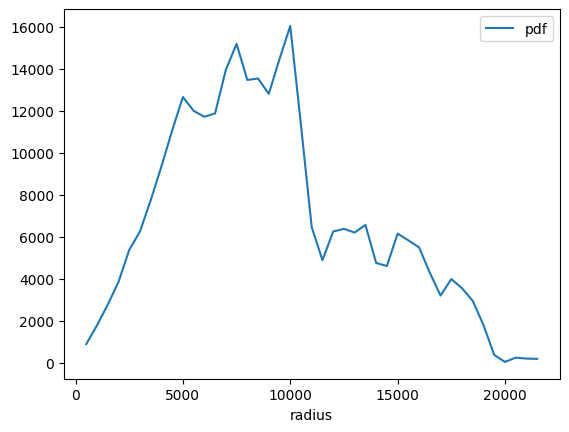

In [28]:
df_houses_interp.plot(x="radius", y="pdf")

# Jobs

In [13]:
df_jobs = pd.read_csv(
    r"C:\Users\lain\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\jobs\denue_2023_estimaciones.csv",
    usecols=["num_empleos_esperados", "latitud", "longitud"]
)

df_jobs = gpd.GeoDataFrame(df_jobs["num_empleos_esperados"], geometry=gpd.points_from_xy(df_jobs["longitud"], df_jobs["latitud"]), crs="EPSG:4326").to_crs("EPSG:6372")

In [19]:
jobs_agg = circles.sjoin(df_jobs, how="inner", predicate="contains").groupby("radius").agg({"num_empleos_esperados": "sum"}).reset_index()

In [36]:
x = jobs_agg["radius"].to_numpy()
y = jobs_agg["num_empleos_esperados"].to_numpy()

df_jobs_interp = generate_cdf_pdf(x, y)
df_jobs_interp.to_csv("./jobs.csv", index=False)

<Axes: xlabel='radius'>

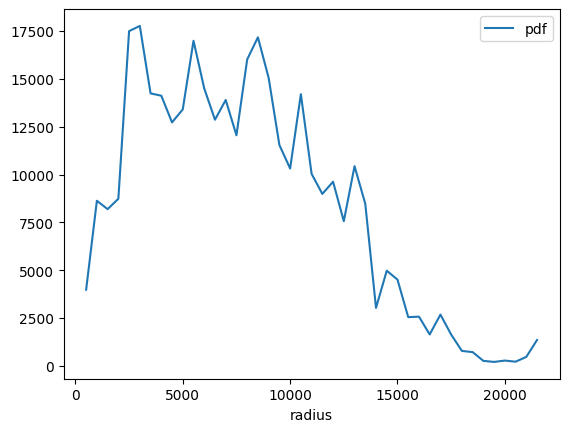

In [ ]:
df_jobs_interp.plot(x="radius", y="pdf")